In [ ]:
import nltk
import re
import numpy as np
import networkx as nx
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from heapq import nlargest

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

def preprocess_text(text):
    """
    Czyści tekst, usuwa znaki specjalne, stop-words i konwertuje na małe litery.
    Zwraca listę zdań i listę zdań do wektoryzacji.
    """
    # Tokenizacja na zdania
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    english_stop_words = stopwords.words('english')
    
    cleaned_sentences = []
    for s in sentences:
        s_clean = re.sub(r'[^a-zA-Z\s]', '', s.lower())
        words = s_clean.split()
        s_processed = ' '.join([word for word in words if word not in english_stop_words])
        cleaned_sentences.append(s_processed)

    return sentences, cleaned_sentences

def textrank_summarize(input_text, summary_percentage=0.3):
    """
    Sumaryzuje tekst metodą TextRank.
    """
    original_sentences, cleaned_sentences = preprocess_text(input_text)

    if not original_sentences or all(not s for s in cleaned_sentences):
        return ""

    num_sentences_to_select = max(1, int(len(original_sentences) * summary_percentage))

    # Krok 1: Wektoryzacja TF-IDF
    # Zamiast używać wyników TF-IDF do bezpośredniej oceny zdań, używamy ich do 
    # stworzenia wektorów zdań, aby móc obliczyć ich podobieństwo.
    vectorizer = TfidfVectorizer()
    
    # Macierz TF-IDF, gdzie każdy wiersz jest wektorem zdania
    sentence_vectors = vectorizer.fit_transform(cleaned_sentences)

    # Krok 2: Budowa Grafu (Macierz Podobieństwa)
    # Oblicz podobieństwo cosinusowe między wszystkimi parami wektorów zdań.
    # To będzie macierz sąsiedztwa grafu, w której wagi krawędzi reprezentują podobieństwo.
    similarity_matrix = cosine_similarity(sentence_vectors)

    # Krok 3: Uruchomienie Algorytmu PageRank (TextRank)
    # Tworzymy graf z macierzy podobieństwa.
    # Węzły = Zdania, Wagi Krawędzi = Podobieństwo Cosinusowe.
    graph = nx.from_numpy_array(similarity_matrix)
    
    # PageRank oblicza "ważność" każdego węzła w grafie (im węzeł jest bardziej 
    # podobny do innych ważnych węzłów, tym wyższy ma ranking).
    scores = nx.pagerank(graph) # Domyślnie używa d=0.85

    # Krok 4: Generowanie Streszczenia
    
    # Przekształcamy wyniki na słownik (zdanie: wynik)
    ranked_sentences = {original_sentences[i]: scores[i] for i in range(len(original_sentences))}

    # Wybieramy N zdań o najwyższych wynikach (używając heapq.nlargest)
    # Zwraca listę tupli (zdanie, wynik)
    best_sentences_with_score = nlargest(num_sentences_to_select, 
                                          ranked_sentences.items(), 
                                          key=lambda item: item[1])
                                          
    best_sentences = [sentence for sentence, score in best_sentences_with_score]
    
    # Rekonstrukcja streszczenia (zachowujemy oryginalną kolejność)
    final_summary = []
    
    for original_sentence in original_sentences:
        if original_sentence in best_sentences:
            final_summary.append(original_sentence)
            
    return " ".join(final_summary)

In [3]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("nvidia/HelpSteer", split="train")

In [4]:
df = df = dataset.to_pandas()

In [5]:
df = df[df["prompt"].str.len() > 1000]
df = df[df["complexity"] == 1]
df = df[df["verbosity"] == 4]
df

,prompt,response,helpfulness,correctness,coherence,complexity,verbosity
1012,Reference:\nMaybe you sold it to buy junk. Tho...,"Who can help the heart, which is grand and ful...",1,1,4,1,4
1234,Read this for context:\n<start of reference>\n...,The reference text suggests that Mr. Nikolai T...,2,3,3,1,4
2002,Reference:\nThe owner of the verified Twitter ...,- The actor Will Smith does not have an offici...,3,2,3,1,4
3352,Read this for context:\nRead More\n\nThere wil...,The potential benefits of the predicted popula...,3,4,3,1,4
4973,Refer to the information below to help with th...,[Sad] [Cinderella] [Ran inside]\n[Angry] [Cind...,2,3,3,1,4
6714,according to the following reference text deli...,Local residents gathered at the Toledo Lucas C...,4,3,4,1,4
7594,The reference text below provides context for ...,Rewarding children for certain behaviors and r...,2,2,3,1,4
7769,Refer to the information below to help with th...,"""The rain comes late, draws the afternoon into...",2,2,2,1,4
8338,Reference:\nTwo days after a naked man stood o...,After the Vatican Gendarmerie took the man to ...,3,4,4,1,4
10800,Reference:\nFormer President Donald Trump has ...,Yes\n\nDonald Trump believes that Kim Reynolds...,2,3,2,1,4


In [6]:
import requests
import time
import json
import os
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("GEMINI_API_KEY")
MODEL_NAME = "gemini-2.5-flash-preview-09-2025"
API_URL = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_NAME}:generateContent"
MAX_RETRIES = 5

def generate_content_with_retry(prompt: str, system_prompt: str) -> dict:
    """
    Sends a request to the Gemini API with exponential backoff for reliability.

    Args:
        prompt: The user query to send to the model.
        system_prompt: The instruction to guide the model's behavior.

    Returns:
        The JSON response from the API, or an empty dictionary on failure.
    """
    if not API_KEY:
        print("Error: API_KEY is missing. Please set your API key.")
        return {}

    # Define the core API request payload
    payload = {
        "contents": [{"parts": [{"text": prompt}]}],
        "systemInstruction": {"parts": [{"text": system_prompt}]},
        # Optional: Add tools:[{"google_search": {}}] here if you need grounding/web search
    }

    headers = {'Content-Type': 'application/json'}
    
    for attempt in range(MAX_RETRIES):
        try:
            # Construct the full URL with the API key
            full_url = f"{API_URL}?key={API_KEY}"
            
            # Use a short timeout suitable for "fast prompting"
            response = requests.post(
                full_url, 
                headers=headers, 
                data=json.dumps(payload),
                timeout=30 # 30 seconds timeout
            )
            response.raise_for_status() # Raises an exception for HTTP errors (4xx or 5xx)
            
            # Success! Return the parsed JSON response
            return response.json()

        except requests.exceptions.HTTPError as e:
            # Handle specific HTTP error codes that suggest retrying
            if response.status_code in [429, 500, 503]: # Too Many Requests, Internal Server Error, Service Unavailable
                delay = 2 ** attempt + 1 # Exponential backoff: 2^0+1, 2^1+1, 2^2+1, ...
                time.sleep(delay)
            else:
                # Other HTTP errors (e.g., 400 Bad Request, 401 Unauthorized) are generally not retryable
                return {}
        
        except requests.exceptions.RequestException as e:
            # Handle network issues, connection errors, and timeouts
            delay = 2 ** attempt + 1
            time.sleep(delay)

    return {}


def ask_prompt(user_prompt):
    """Main function to run the fast prompting script."""
    
    # 2. Define the system instruction for 'fast' and concise output
    system_instruction = (
        "You are an extremely fast and concise AI assistant. Your responses must be "
        "direct, short, and immediately answer the user's query without any preamble or fluff. "
    )

    
    # Send the request
    api_response = generate_content_with_retry(user_prompt, system_instruction)
    
    if api_response:
        # Extract the text content
        try:
            text_response = api_response['candidates'][0]['content']['parts'][0]['text']
            return text_response
        except (KeyError, IndexError) as e:
            print(f"Error parsing response structure: {e}")
    else:
        print("Could not retrieve content from the API.")

    

In [26]:
df_test = df[["prompt", "response"]]
df_test = df_test[:3]

#prompt_responses = [ask_prompt(dt) for dt in df_test["prompt"]]

In [21]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
def evaluate(prompt, threshold, metric):
    prompt_summarized = textrank_summarize(prompt, summary_percentage=threshold)
    if metric == "cosin":
    # Krok 1: Inicjalizacja Modelu Osadzania
    # all-MiniLM-L6-v2 jest szybki i zapewnia dobrą jakość osadzania zdań.
        model = SentenceTransformer('all-MiniLM-L6-v2') 
        # Krok 2: Generowanie Wektorów Osadzania
        sentences = [prompt, prompt_summarized]
        embeddings = model.encode(sentences)

        # P_orig to pierwszy wektor, P_short to drugi wektor
        P_orig = embeddings[0].reshape(1, -1)
        P_short = embeddings[1].reshape(1, -1)

        # Krok 3: Obliczanie Podobieństwa Cosinusowego
        # Funkcja cosine_similarity zwraca macierz, bierzemy pierwszy element.
        similarity_score = cosine_similarity(P_orig, P_short)[0][0]

        return similarity_score
    elif metric == "api":
        percent = ask_prompt("Compare two answers, decide if they are logically the same, answer in [0, 100], first: " + ask_prompt(prompt) + " second: " + ask_prompt(prompt_summarized))
        return int(percent)

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def evaluate_summarization_and_plot_v2(original_prompt, evaluate_function, metric_type="cosin"):
    """
    Testuje efektywność algorytmu sumaryzacji (poprzez funkcję evaluate)
    dla różnych progów skrótu i generuje wykres wyników.
    
    Args:
        original_prompt (str): Pełny, oryginalny prompt do sumaryzacji.
        evaluate_function (function): Twoja funkcja 'evaluate(prompt, threshold, metric)'.
        metric_name (str): Nazwa metryki do wyświetlenia na wykresie ('Cosinusowe' lub 'API').
    """
    
    # 1. Przygotowanie danych
    
    # Zakres progów skrótu (threshold) do przetestowania (od 10% do 90%)
    percentage_range = np.arange(0.3, 1.0, 0.2) 
    
    # Zmienne do przechowywania wyników
    scores = []
    
    # Używamy metryki "cosin" lub "api"
    
    
    print(f"--- Rozpoczynanie Testu Sumaryzacji (Metryka: {metric_type}) ---")
    
    # 2. Iteracyjne Testowanie
    
    for p in percentage_range:
        percent = round(p, 2) 
        
        # Wywołanie Twojej funkcji 'evaluate'
        try:
            similarity_score = evaluate_function(
                prompt=original_prompt, 
                threshold=percent, 
                metric=metric_type
            )
            scores.append(similarity_score)
            
            # Wypisujemy wynik dla bieżącego progu
            print(f"Skrót: {int(percent * 100)}% | Wynik: {similarity_score:.4f}")
            
        except Exception as e:
            # Obsługa błędów, np. jeśli brakuje funkcji 'textrank_summarize' lub 'ask_prompt'
            print(f"Błąd podczas testowania dla progu {int(percent * 100)}%: {e}")
            scores.append(0.0) # Dodajemy zero, aby kontynuować

    # 3. Generowanie Wykresu
    
    # Konwersja procentów na wartości do wyświetlenia (10, 20, 30...)
    x_labels = [f'{int(p * 100)}%' for p in percentage_range]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, scores, marker='o', linestyle='-', color='indigo')
    
    plt.title(f'Ocena Semantyczna Skróconego Promptu (Metryka: {metric_type})')
    plt.xlabel('Procent Długości Oryginalnego Promptu (%)')
    plt.ylabel(f'Podobieństwo / Ocena ({metric_type})')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Skalowanie osi Y zależne od metryki
    max_score = 1.05 if metric_type == "cosin" else 105
    plt.ylim(0.0, max_score) 
    
    # Dodanie linii referencyjnej
    if metric_type == "cosin":
        plt.axhline(y=0.85, color='r', linestyle='--', label='Wysokie Podobieństwo (0.85)')
    elif metric_type == "api":
        plt.axhline(y=80, color='r', linestyle='--', label='Wysoka Zgodność (80)')
        
    plt.legend()
    plt.show() 
    
    return percentage_range, scores

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def test_multiple_prompts_with_average(prompts, evaluate_function, metric_name='cosin'):
    """
    Testuje efektywność algorytmu sumaryzacji dla wielu promptów,
    zbiera wyniki i generuje jeden wykres pokazujący średnią wydajność 
    w zależności od progu skrótu, wraz z odchyleniem standardowym.
    
    Args:
        prompts_dict (dict): Słownik, gdzie kluczem jest nazwa testu (str), 
                             a wartością jest oryginalny prompt (str).
        evaluate_function (function): Twoja funkcja 'evaluate(prompt, threshold, metric)'.
        metric_name (str): Metryka używana do ewaluacji ('cosin' lub 'api').
    """
    
    # 1. Konfiguracja testu
    
    # Zakres progów skrótu (threshold) do przetestowania (od 10% do 90%)
    percentage_range = np.arange(0.3, 1.0, 0.2) 
    
    # Słownik przechowujący WSZYSTKIE wyniki dla każdego progu skrótu
    all_scores_by_threshold = {round(p, 2): [] for p in percentage_range}
    
    # Mapowanie metryki dla lepszego wyświetlania na wykresie
    
    print("=====================================================")
    print(f"Rozpoczynanie Testów dla Wielu Promptów (Metryka: {metric_name})")
    print("=====================================================")

    # 2. Zbieranie Wyników
    
    for original_prompt in prompts:
        
        for p in percentage_range:
            percent = round(p, 2) 
            
            try:
                # Wywołanie Twojej funkcji 'evaluate'
                similarity_score = evaluate_function(
                    prompt=original_prompt, 
                    threshold=percent, 
                    metric=metric_name
                )
                
                # Dodajemy wynik do listy dla bieżącego progu skrótu
                all_scores_by_threshold[percent].append(similarity_score)
                
            except Exception as e:
                print(f"Błąd dla promptu przy {int(percent * 100)}%: {e}. Pomijanie.")
                pass 

    # 3. Obliczanie Średnich i Odchyleń Standardowych
    
    average_scores = []
    std_deviations = []
    x_labels = []

    for percent, scores_list in all_scores_by_threshold.items():
        if scores_list:
            average_scores.append(np.mean(scores_list))
            std_deviations.append(np.std(scores_list))
            x_labels.append(f'{int(percent * 100)}%')
        else:
             # Używamy NaN, jeśli nie ma danych, ale 0.0 jest bezpieczniejsze dla wyświetlania
             average_scores.append(0.0)
             std_deviations.append(0.0)
             x_labels.append(f'{int(percent * 100)}%')


    # 4. Generowanie Pojedynczego Wykresu
    
    plt.figure(figsize=(12, 7))
    
    # Wykres średniej
    plt.plot(x_labels, average_scores, marker='o', linestyle='-', color='darkgreen', 
             label=f'Średnie Podobieństwo ({len(prompts)} promptów)')
    
    # Dodanie paska błędu/rozrzutu (odchylenie standardowe)
    # yerr='std_deviations' oznacza, że pionowe paski pokazują zakres odchylenia
    plt.errorbar(x_labels, average_scores, yerr=std_deviations, fmt='o', color='darkgreen', 
                 ecolor='lightgreen', capsize=5, alpha=0.6, label='Rozrzut (Odchylenie Standardowe)')
    
    plt.title(f'Średnia Wydajność Sumaryzatora w Zależności od Skrótu (Metryka: {metric_name})')
    plt.xlabel('Procent Długości Oryginalnego Promptu (%)')
    plt.ylabel(f'Średnia Ocena')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Skalowanie osi Y
    max_score = 1.05 if metric_name == "cosin" else 105
    plt.ylim(0.0, max_score) 
    
    # Dodanie linii referencyjnej
    ref_line_y = 0.85 if metric_name == "cosin" else 80
    plt.axhline(y=ref_line_y, color='r', linestyle='--', label=f'Próg Wysokiej Jakości ({ref_line_y})')
        
    plt.legend()
    # 
    plt.show() 
    
    return percentage_range, average_scores, std_deviations

Rozpoczynanie Testów dla Wielu Promptów (Metryka: cosin)


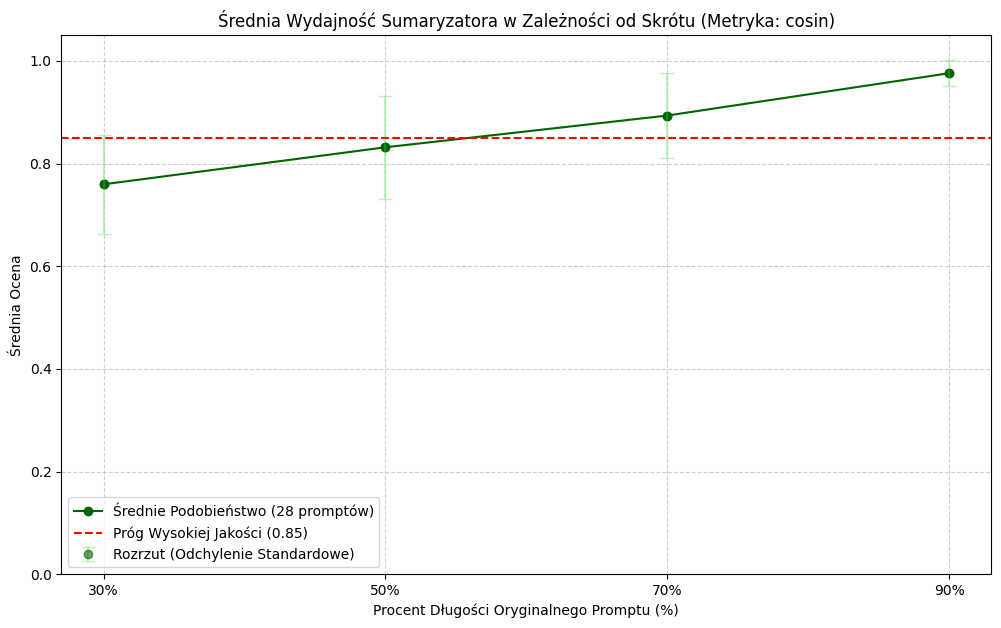

(array([0.3, 0.5, 0.7, 0.9]),
 [np.float32(0.7595803),
  np.float32(0.83168924),
  np.float32(0.8935016),
  np.float32(0.975963)],
 [np.float32(0.095909566),
  np.float32(0.100752056),
  np.float32(0.08320148),
  np.float32(0.025609506)])

In [41]:
test_multiple_prompts_with_average(df["prompt"], evaluate_function=evaluate)

In [ ]:
test_multiple_prompts_with_average(df["prompt"], evaluate_function=evaluate, metric_name="api")